In [1]:
import numpy as np
from matplotlib import pyplot as plt
import py_gauge_mc
import os
from tqdm import tqdm
import scipy.special

In [2]:
def v_tilde(ns, k):
    return (1.0/k) * ns**2
#     return - np.log(scipy.special.jv(ns, k) / scipy.special.jv(0, k))

In [3]:
def get_states(inv_k, L=8, n_exp=16, samples=128,local_updates_per_step=10,steps_per_sample=10):
    vns = v_tilde(np.arange(0,100), 1./inv_k).astype(np.float32)
    vns = np.tile(vns, [n_exp, 1])
    
    graph = py_gauge_mc.GPUGaugeTheory((L,L,L,L),vns)
    graph.run_local_update(1000)
    return graph.simulate_and_get_states(samples,
                                         local_updates_per_step=local_updates_per_step,
                                         steps_per_sample=steps_per_sample)

def autocorr(x):
    L = x.shape[-1]
    dat = np.zeros((L,))
    for i in range(x.shape[-1]):
        for j in range(x.shape[-1]):
            corr = (x[:,i] * x[:,j]).mean() - (x[:,i].mean()*x[:,j].mean())
            dat[(j-i+L)%L] += corr
    return dat/L

In [8]:
def corr_for(L=16,inv_k=0.25):
    states = get_states(inv_k, L=L)
    states = states.reshape((-1, L, L, L, L, 6))
    # Just keep the t-x plaquettes for t=0 and x=0
    states = states[...,0,0,:,:,0]
    # For now keep z=0 just vary y
    substates = states[:,:,0]
    return autocorr(substates)

In [10]:
L = 16
corrs = []
for inv_k in np.linspace(0.2,1.6,8):
    corr = corr_for(L=16,inv_k=inv_k)
    corrs.append(corr)
corrs = np.array(corrs)

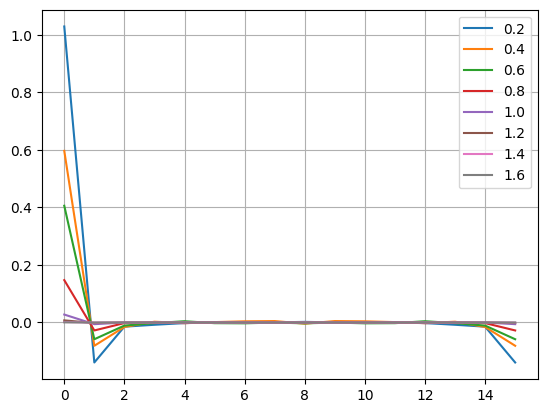

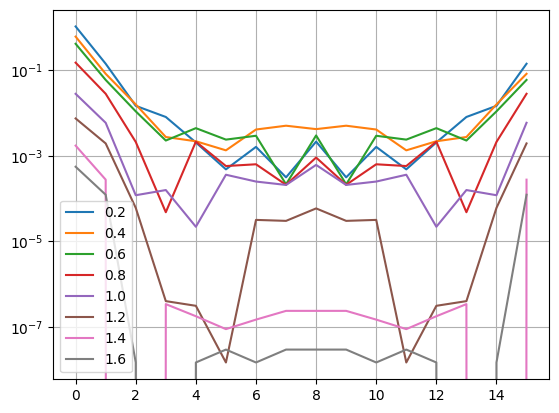

In [20]:
L = 16
for (corr, inv_k) in zip(corrs, np.linspace(0.2,1.6,8)):
    plt.plot(corr, label="{:.1f}".format(inv_k))

plt.grid()
plt.legend()
plt.show()


for (corr, inv_k) in zip(corrs, np.linspace(0.2,1.6,8)):
    plt.plot(np.abs(corr), label="{:.1f}".format(inv_k))

plt.yscale('log')
plt.grid()
plt.legend()
plt.show()